In [1]:
import numpy as np
import pickle
import cv2
import matplotlib.pyplot as plt

from os                         import listdir

from sklearn.preprocessing      import LabelBinarizer
from tensorflow.keras.models    import Sequential

#from keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers    import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core          import Activation, Flatten, Dropout, Dense
from keras                      import backend as K
from keras.preprocessing.image  import ImageDataGenerator
from keras.optimizers           import Adam
from keras.preprocessing        import image

#from keras.preprocessing.image import img_to_array
from tensorflow.keras.utils     import img_to_array
from sklearn.preprocessing      import MultiLabelBinarizer
from sklearn.model_selection    import train_test_split

In [2]:
# example of loading an image with the Keras API
from tensorflow.keras.utils     import load_img

In [3]:
EPOCHS = 30
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = 'C:/Users/Hp/OneDrive/Desktop/reddybr/x'
width=256
height=256
depth=3

Function to convert images to array

In [4]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

Fetch images from directory

In [5]:
import os
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:500]:
                image_path = os.path.join(directory_root, plant_folder, plant_disease_folder, image)
                if image_path.endswith(".jpg") == True or image_path.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_path))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Pepper__bell___Bacterial_spot ...
[INFO] Processing Pepper__bell___healthy ...
[INFO] Processing PlantVillage ...
[INFO] Processing Potato___Early_blight ...
[INFO] Processing Potato___healthy ...
[INFO] Processing Potato___Late_blight ...
[INFO] Processing Tomato_Bacterial_spot ...
[INFO] Processing Tomato_Early_blight ...
[INFO] Processing Tomato_healthy ...
[INFO] Processing Tomato_Late_blight ...
[INFO] Processing Tomato_Leaf_Mold ...
[INFO] Processing Tomato_Septoria_leaf_spot ...
[INFO] Processing Tomato_Spider_mites_Two_spotted_spider_mite ...
[INFO] Processing Tomato__Target_Spot ...
[INFO] Processing Tomato__Tomato_mosaic_virus ...
[INFO] Processing Tomato__Tomato_YellowLeaf__Curl_Virus ...
[INFO] Image loading completed


Get Size of Processed Image

In [6]:
image_size = len(image_list)

Transform Image Labels uisng [Scikit Learn](http://scikit-learn.org/)'s LabelBinarizer

In [7]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

Print the classes

In [8]:
print(label_binarizer.classes_)

['Pepper__bell___Bacterial_spot' 'Pepper__bell___healthy'
 'Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy'
 'Tomato_Bacterial_spot' 'Tomato_Early_blight' 'Tomato_Late_blight'
 'Tomato_Leaf_Mold' 'Tomato_Septoria_leaf_spot'
 'Tomato_Spider_mites_Two_spotted_spider_mite' 'Tomato__Target_Spot'
 'Tomato__Tomato_YellowLeaf__Curl_Virus' 'Tomato__Tomato_mosaic_virus'
 'Tomato_healthy']


In [9]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [10]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

[INFO] Spliting data to train, test


In [11]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [12]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

Model Summary

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 85, 85, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        1

In [14]:
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


In [15]:
history = model.fit(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

Epoch 1/30
175/175 [==============================] - 490s 3s/step - loss: 0.3738 - accuracy: 0.3613 - val_loss: 1.3218 - val_accuracy: 0.0669
Epoch 2/30
175/175 [==============================] - 473s 3s/step - loss: 0.1362 - accuracy: 0.6340 - val_loss: 0.7490 - val_accuracy: 0.1153
Epoch 3/30
175/175 [==============================] - 471s 3s/step - loss: 0.1110 - accuracy: 0.7051 - val_loss: 0.2790 - val_accuracy: 0.3580
Epoch 4/30
175/175 [==============================] - 474s 3s/step - loss: 0.0986 - accuracy: 0.7502 - val_loss: 0.2789 - val_accuracy: 0.5509
Epoch 5/30
175/175 [==============================] - 474s 3s/step - loss: 0.0845 - accuracy: 0.8037 - val_loss: 0.1268 - val_accuracy: 0.6762
Epoch 6/30
175/175 [==============================] - 475s 3s/step - loss: 0.0846 - accuracy: 0.8014 - val_loss: 0.2903 - val_accuracy: 0.4840
Epoch 7/30
175/175 [==============================] - 470s 3s/step - loss: 0.0712 - accuracy: 0.8345 - val_loss: 0.3869 - val_accuracy: 0.5488

In [16]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


Plot the train and val curve

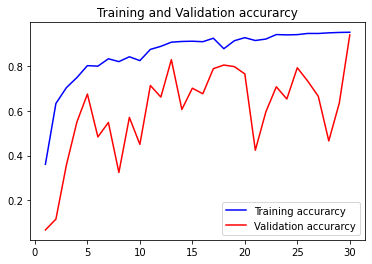

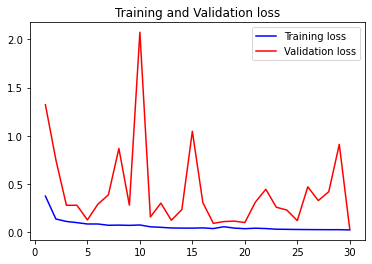

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

Model Accuracy

In [18]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
44/44 [==============================] - 23s 521ms/step - loss: 0.0278 - accuracy: 0.9416
Test Accuracy: 94.16370391845703


Save model using Pickle

In [19]:
# save the model to disk
print("[INFO] Saving model...")
model.save('my_model.h5')

[INFO] Saving model...


In [20]:
from tensorflow import keras

loaded_model = keras.models.load_model('my_model.h5')

In [21]:
image_dir = r"C:\Users\Hp\OneDrive\Desktop\reddybr\x\PlantVillage\Pepper__bell___Bacterial_spot\1.JPG"
im1 = load_img(image_dir)

im=convert_image_to_array(image_dir)
np_image_li = np.array(im, dtype=np.float16) / 225.0
npp_image = np.expand_dims(np_image_li, axis=0)


In [22]:
result=model.predict(npp_image)
print(result)

1/1 [==============================] - 1s 1s/step
[[1.0000000e+00 2.2612342e-14 1.9793592e-12 7.2537089e-17 4.3927861e-18
  3.3959670e-13 5.3875171e-10 4.3909812e-16 3.3828497e-17 1.9487905e-09
  1.3975204e-19 1.0679353e-15 5.4279269e-18 2.4743825e-22 6.1974657e-19]]


In [23]:
itemindex = np.where(result==np.max(result))
print("probability:"+str(np.max(result))+"\n"+label_binarizer.classes_[itemindex[1][0]])

probability:1.0
Pepper__bell___Bacterial_spot
